<a href="https://colab.research.google.com/github/MichalSlowakiewicz/Machine-Learning/blob/master/Homework6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment: Understanding Splitting Criteria in CART for Regression**
---------------------

In this assignment, you will explore three common formulations of the splitting criterion used in **CART (Classification and Regression Trees)** for **regression problems**:

1. **Local RSS Minimization**  
2. **RSS Gain Maximization**  
3. **Total RSS Minimization**

You will investigate whether any of these criteria are equivalent, and you will design an experiment to determine which criterion is actually employed in a standard implementation such as **scikit-learn’s DecisionTreeRegressor**.



## **The Problem**

Many treatments of CART for regression describe the split selection process in different ways. Below are three frequently cited formulations. Suppose we have a dataset with features $X$ and target $y$, and we seek to choose a feature $X_j$ and a threshold $t$ to split the data into two regions $R_1(X_j, t)$ and $R_2(X_j, t)$. Denote by $\bar{y}_{R_m}$ the mean of targets within region $R_m$.

1. **Local RSS Minimization**  
   We select the feature and threshold that minimize the **sum of squared errors** in the two resulting child nodes:
   $$
   (X_j^*, t^*) = \arg\min_{X_j, t} \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2.
   $$

2. **RSS Gain Maximization**  

   It is also a local method, looking only at a parent and two child nodes.

   We select the feature and threshold that maximize the **reduction** in RSS, computed by subtracting the RSS of the two child nodes from the RSS in the parent node:
   $$
   (X_j^*, t^*) = \arg\max_{X_j, t} \Bigl\{
   \underbrace{\sum_{i : x_i \in \text{Parent}} (y_i - \bar{y})^2}_{\text{Parent RSS}}
   \;-\;
   \underbrace{\sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2}_{\text{Children RSS}}
   \Bigr\}.
   $$

3. **Total RSS Minimization**  
   For a dataset $\{(x_i, y_i)\}_{i=1}^N$ with features $X$ and target $y$, let $T$ be the current tree.

   For any split on feature $X_j$ at threshold $t$, define $T(X_j, t)$ as the new tree obtained by splitting one leaf of $T$ into two leaves $R_1(X_j, t)$ and $R_2(X_j, t)$.
   
   Let $\mathrm{Leaves}(T(X_j, t))$ be the set of all leaf indices in this new tree. For each leaf $m \in \mathrm{Leaves}(T(X_j, t))$, define:
   $$
   R_m = \{\, i \,\mid\, x_i \text{ ends in leaf } m\}.
   $$

   $R_m$ set collects all data indices $i$ whose feature vector $x_i$ is classified into the leaf node $m$ when passed through the tree $T(X_j,t)$. In other words, each leaf node $m$ in $T(X_j, t)$ corresponds to a unique path of splits, and any data point $x_i$ that follows that path is assigned to the leaf $m$; hence, it belongs to $R_m$.

   $R_m$ sets for all leafs $m \in \mathrm{Leaves}(T(X_j, t))$ define a partition of all indices.

   Then the objective of **minimizing total Residual Sum of Squares (total RSS)** is stated as:
   $$
   (X_j^*, t^*) = \arg\min_{(X_j, t)} \sum_{m \in \mathrm{Leaves}(T(X_j, t))}
   \sum_{i \in R_m} \Bigl(y_i - \overline{y}_{R_m}\Bigr)^2,
   $$
   where
   $$
   \overline{y}_{R_m} = \frac{1}{\lvert R_m \rvert}
   \sum_{i \in R_m} y_i
   $$
   is the mean response in leaf $m$.


## **Research Questions**

1. **Equivalence Analysis**  
   Determine whether the above formulations are equivalent or if they can yield different split choices. Specifically:
   - Are *local RSS minimization* and *RSS gain maximization* equivalent?
   - Does *total RSS minimization* coincide with either of these two, or is it distinct?
   
2. **Empirical Experiment**  
   Design and conduct a Python experiment to determine which of these formulations is implemented in `scikit-learn` in `DecisionTreeRegressor`. Present numerical results and plots to support your conclusion.


## **Tasks & Deliverables**

1. **Formulation Analysis**  
   - Compare *local RSS minimization*, *RSS gain maximization*, and *total RSS minimization*.
   - If you find that any pair of formulations is equivalent, provide a concise proof.  
   - If you find that they differ, construct a counterexample.

2. **Empirical Verification**  
   - Create a small artificial dataset and train a `DecisionTreeRegressor` from `scikit-learn`.
   - The dataset must be designed in a way that uniquely identifies the formulation used. Provide a short code snippet and a plot or table to support your conclusion.

3. **Report**  
   - Summarize your theoretical insights and empirical findings in a **Colab notebook**.
   - Include the relevant proofs, code, discussion, and conclusions.
   - Place the notebook in your **GitHub repository** for this course, add a link to it in your README.md and add an **“Open in Colab”** badge in the notebook so it can be launched directly.



**1) Are local RSS minimization and RSS gain maximization equivalent?**

**2) Does total RSS minimization coincide with either of these two, or is it distinct?**

Metody *local RSS minimization* oraz *RSS gain maximization* są sobie równoważne. Natomiast, *total RSS minimization* nie jest równoważna z powyższymi metodami.

1) Metoda *local RSS minimization* minimalizuje kolejne sumy błędów kwadratowych "dzieci", natomiast, *RSS gain maximization* maksymalizuje przyrost RSS. Ustalmy konkretny węzeł ("rodzica") w drzewie. Rozważymy w jaki sposób postępują obie metody w ustalaniu granicy dla "dzieci".
*Local RSS minimization* minimalizuje wyrażenie: *RSS(R1)+RSS(R2)*, a *RSS gain maximization* maksymalizuje *RSS_rodzica-(RSS(R1)+RSS(R2))*. Zauważmy, że *RSS_rodzica* jest ustalone, zatem *RSS gain maximization* równoważnie maksymalizuje wartość *-(RSS(R1)+RSS(R2))*. Z kolei to jest równoważne z minimalizacją wartości *(RSS(R1)+RSS(R2))*, czym zajmuje się *local RSS minimization*.
Dlatego, metody *local RSS minimization* oraz *RSS gain maximization* są sobie równoważne.

2) Aby pokazać, iż *total RSS minimization* nie jest równoważna z pozostałymi dwoma metodami, gdyż może dojść do sytuacji, gdy pewnien podział nie minimalizuje lokalnie RSS, ale za to pozwala zminimalizować całkowite RSS. Poniżej zostanie zaprezentowany kontrprzykład:


scikit-learn's first split threshold: 2.5

Local RSS evaluation for first split:
Split at 1.5: RSS = 36.9
Split at 2.5: RSS = 9.3
Split at 3.5: RSS = 16.7
Split at 4.5: RSS = 17.0
Split at 5.5: RSS = 29.5
Split at 6.5: RSS = 37.3
Split at 7.5: RSS = 48.9

Total RSS evaluation for different first splits:
First split at 1.5: Total RSS = 9.3
First split at 2.5: Total RSS = 1.0
First split at 3.5: Total RSS = 1.0
First split at 4.5: Total RSS = 0.0
First split at 5.5: Total RSS = 2.7
First split at 6.5: Total RSS = 4.0
First split at 7.5: Total RSS = 7.2


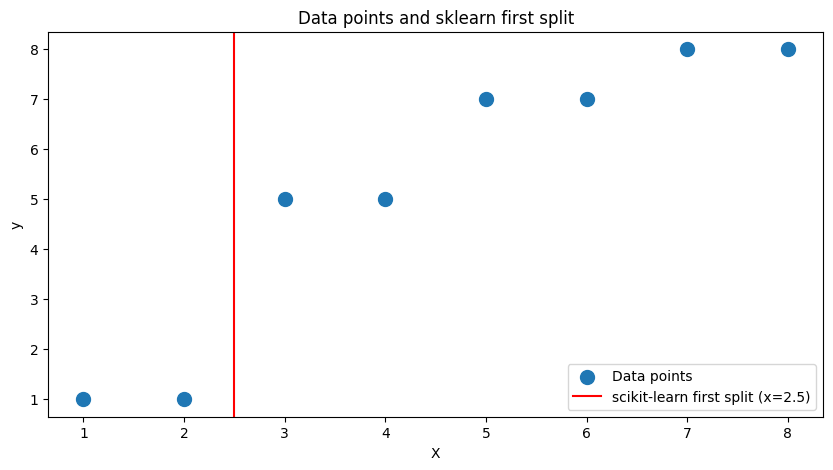

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# let's analyze tree with max_depth = 2

# creating a dataset for counterexample
X = np.array([1, 2, 3, 4, 5, 6, 7, 8]).reshape(-1, 1)
y = np.array([1, 1, 5, 5, 7, 7, 8, 8])

# fitting DecisionTreeRegressor with max_depth=2 to see splits
dt = DecisionTreeRegressor(max_depth=2)
dt.fit(X, y)

# getting the first split using sklearn
sklearn_first_split = dt.tree_.threshold[0]
print(f"\nscikit-learn's first split threshold: {sklearn_first_split}")

# function computing Local RSS for possible first splits
def compute_rss(y_subset):
    return np.sum((y_subset - np.mean(y_subset))**2) if len(y_subset) > 0 else 0

# defining all possible splits
possible_splits = [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]

# calculating and printing Local RSS values for all possible splits
print("\nLocal RSS evaluation for first split:")
for t in possible_splits:
    left = y[X.flatten() <= t]
    right = y[X.flatten() > t]
    rss = compute_rss(left) + compute_rss(right)
    print(f"Split at {t}: RSS = {rss:.1f}")

# defining function which will be used in finding second split for Total RSS Minimization
def find_best_split(X_subset, y_subset):
    if len(X_subset) <= 1:
        return compute_rss(y_subset)
    splits = (X_subset[:-1] + X_subset[1:])/2
    best_rss = float('inf')
    for t in splits:
        l = y_subset[X_subset.flatten() <= t]
        r = y_subset[X_subset.flatten() > t]
        current_rss = compute_rss(l) + compute_rss(r)
        if current_rss < best_rss:
            best_rss = current_rss
    return best_rss

# calculating and printing Total RSS values for all possible splits
print("\nTotal RSS evaluation for different first splits:")
for t1 in possible_splits:

    # first split
    left_mask = X.flatten() <= t1
    right_mask = X.flatten() > t1

    # second splits
    left_X, left_y = X[left_mask], y[left_mask]
    right_X, right_y = X[right_mask], y[right_mask]

    # finding best second split
    left_rss = find_best_split(left_X, left_y)
    right_rss = find_best_split(right_X, right_y)
    total_rss = left_rss + right_rss
    print(f"First split at {t1}: Total RSS = {total_rss:.1f}")

# plotting
plt.figure(figsize=(10, 5))
plt.scatter(X, y, s=100, label='Data points')
plt.axvline(sklearn_first_split, color='red',
            label=f'scikit-learn first split (x={sklearn_first_split})')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Data points and sklearn first split')
plt.legend()
plt.show()


In [19]:
dt.tree_.threshold

array([ 2.5, -2. ,  4.5, -2. , -2. ])

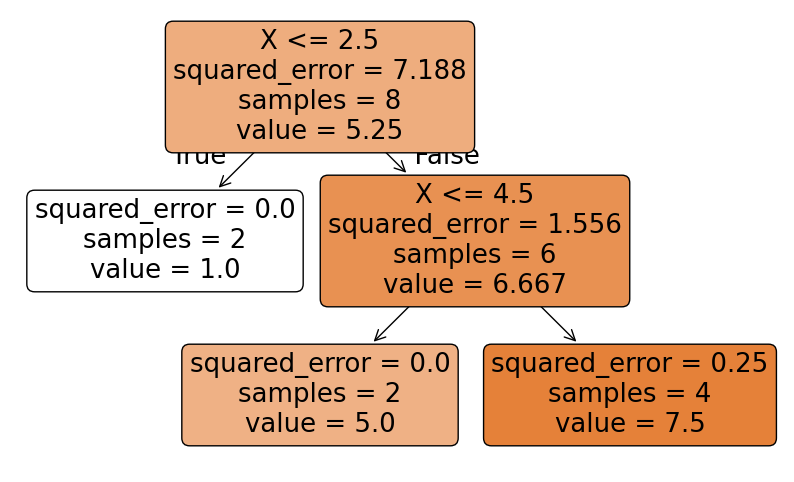

In [21]:
from sklearn.tree import  plot_tree
plt.figure(figsize=(10, 6))
plot_tree(dt, filled=True, feature_names=["X"], rounded=True)
plt.show()

Jak możemy zauważyć powyżej, *Total RSS Minimization* wybrało punkt 4.5 jako pierwszy podział, podczas gdy *Local RSS Minimization* wzięło punkt 2.5, co pokazuje brak równoważności tych metod.

Metoda zaimplementowana w bibliotece *scikit-learn* daje takie same rezultaty jak *Local RSS Minimization*: podział w x = 2.5. Można zatem stwierdzić, iż *scikit-learn* korzysta z metody równoważnej *Local RSS Minimization*.